#### Time series data prediction 

In [24]:
#dowloading the apple stock market dataset
!wget https://raw.githubusercontent.com/abhinav-TB/Time-Series-Forecasting-Uisng-LSTM/master/AAPL.csv 

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [25]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
df = pd.read_csv('AAPL.csv')


In [26]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [27]:
df1 = df.reset_index()['close']

In [28]:
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

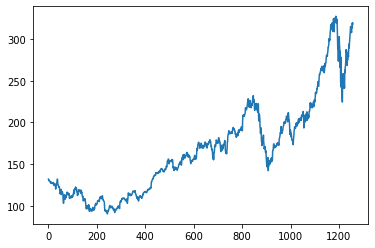

In [29]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [30]:
# normalising the dataset to values bewtween 0 and 1

import numpy as np
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0,1))
df1 = scalar.fit_transform(np.array(df1).reshape(-1,1))

In [31]:
df1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

In [32]:
##splitting dataset into train and test split for time series data
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


In [33]:
class StockDataset(Dataset):
    def __init__(self,data,seq_len = 100):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.seq_len] , self.data[index+self.seq_len]


train_dataset = StockDataset(train_data) 
test_dataset = StockDataset(test_data) 





In [34]:
batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size,drop_last=True)
test_dataloader = DataLoader(test_dataset,batch_size , drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim , hidden_size = hidden_size , num_layers= num_layers )
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn))
        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def predict(self,x):
        hn,cn  = self.init()
        final_out = self.fc(out[-1])
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0


input_dim = 1 
hidden_size = 50
num_layers = 3

model = Lstm_model(input_dim , hidden_size , num_layers).to(device)



In [36]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [37]:
def train(dataloader):
    hn , cn = model.init()
    model.train()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(100,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"train loss: {loss:>7f} ")


In [38]:
def test(dataloader):
    hn , cn = model.init()
    model.eval()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(100,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
       
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"test loss: {loss:>7f} ")


In [39]:
epochs = 200
for epoch in range(epochs):
    print(f"epoch {epoch} ")
    train(train_dataloader)
    test(test_dataloader)

epoch 0 
train loss: 0.046887 
test loss: 0.337733 
epoch 1 
train loss: 0.051463 
test loss: 0.405583 
epoch 2 
train loss: 0.061453 
test loss: 0.422875 
epoch 3 
train loss: 0.051161 
test loss: 0.389310 
epoch 4 
train loss: 0.045799 
test loss: 0.371885 
epoch 5 
train loss: 0.047503 
test loss: 0.372931 
epoch 6 
train loss: 0.047899 
test loss: 0.366587 
epoch 7 
train loss: 0.045431 
test loss: 0.348493 
epoch 8 
train loss: 0.042390 
test loss: 0.321653 
epoch 9 
train loss: 0.038049 
test loss: 0.269954 
epoch 10 
train loss: 0.026545 
test loss: 0.114938 
epoch 11 
train loss: 0.005423 
test loss: 0.047194 
epoch 12 
train loss: 0.050240 
test loss: 0.136277 
epoch 13 
train loss: 0.010519 
test loss: 0.044378 
epoch 14 
train loss: 0.007722 
test loss: 0.021536 
epoch 15 
train loss: 0.000368 
test loss: 0.029508 
epoch 16 
train loss: 0.000450 
test loss: 0.025514 
epoch 17 
train loss: 0.009375 
test loss: 0.020214 
epoch 18 
train loss: 0.001855 
test loss: 0.017552 
epo

In [40]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(100,64,1)
            pred = model(x,hn,cn)[0]
            pred = scalar.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scalar.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        print(pred_arr[21],y_arr[21])
        return math.sqrt(mean_squared_error(y_arr,pred_arr))
    

In [41]:
# calculating final loss metrics
print(f"train mse loss {calculate_metrics(train_dataloader)}")
print(f"test mse loss {calculate_metrics(test_dataloader)}")

118.904 114.174995
train mse loss 8.110066937453752
178.2763 170.42
test mse loss 31.361303736775877
